<center>
    <img src="./images/msp_header.png">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

# DCT and Polyphase Representation

In [7]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/sPXt7PBBwnw" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

## Notation

Last time we saw the equvalent impulse responses for analysis and synthesis for the DFT. Observe that our convention is to multiply the **signal vector** (a **row vector**) from the **left hand side** onto the transform matrix. In the literature, also the other way around is used, with the **signal vector** beeing a **column vector** multiplied from the **right hand side** onto the transform matrix. The transform matrix is then also the transposed version.

This is our Notation:

$$\large
\mathbf{X_{1xN} \cdot T_{NxN} = Y_{1xN}}
$$

This has the advantage that it **corresponds to a signal flow diagram**, from left to right. The following is an alternative notation.

$$\large
\mathbf{Y_{Nx1} =  T_{NxN} \cdot X_{Nx1}}
$$

It correponds more to the **mathematical notation of functions**, from right to left.

## Discrete Cosine Transform (DCT)

In [8]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/pom33DKz96U" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

Another widely used block transform is the Discrete Cosine Transform. The **DCT Type 4** is defined as (see lecture 2).

$$\large
y_k(m)=\sqrt{\frac{2}{ N}} \sum _ {n=0}^ {N-1} x(mN+n) \cdot  cos \left(\frac{\pi} {N} (n+0.5)(k+0.5) \right)
$$

for the analysis (k=0,...,N-1). Characteristic here is the shift of 0.5 in the subband index k and the time index n.

As a comparison, the **DCT Type 2** analysis transform is defined as

$$\large
y_k(m)=c_k \cdot \sqrt{\frac{2}{ N}} \sum _ {n=0}^ {N-1} x(mN+n) \cdot  cos \left(\frac{\pi} {N} (n+0.5)(k) \right)
$$

where $c_0=\sqrt{0.5}$, and $c_k = 1$ for k > 0, with k=0,...,N-1.

Observe that the only difference is that the DCT 4 also has a shift of 0.5 for the frequency index k.

The DCT 2 is mostly used for images and video coding, whereas the DCT 4 is mostly used for audio signals.

Using the definition of the DCT 4, we can now construct the transform matrix and extract the **equivalent impulse responses.** The analysis transform matrix becomes:

$$\large
\mathbf{T_{n,k}}=\sqrt{\frac{2}{ N}}  cos \left(\frac{\pi} {N} (n+0.5)(k+0.5) \right)
$$

The impulse response of the **equivalent analysis filters** are the time-reversed columns,

$$\large
h_k(n)=\sqrt{\frac{2}{ N}}  cos \left(\frac{\pi} {N} (N-1+n+0.5)(k+0.5) \right)
$$

In this way we get N impulse responses.

The synthesis impulse responses are simply the rows of this transform matrix (which in this case is identical to the columns),

$$\large
g_k(n)=\sqrt{\frac{2}{ N}}  cos \left(\frac{\pi} {N} (n+0.5)(k+0.5) \right)
$$

We see that they are simply the **time-reversed analysis filter** (since here we don't need time reversal).

Here we have **perfect reconstruction** filter banks, with **critical sampling**, both desirable properties for coding. But our  equivalent filters are **restricted to a length of N**. This leads to filters which do not really have good frequency responses, we get wide transition bands for our band pass filters relative to the width of the passband, and not enough stopband attenuation.

In Python we get the transform matrix for the DCT 4 as:

In [7]:
import numpy as np

N=4
T=np.zeros((4,4))

for n in range(4):
    for k in range(4):
        T[n,k]=np.cos(np.pi/4*(n+0.5)*(k+0.5))*np.sqrt(2.0/N)
T

array([[ 0.69351992,  0.5879378 ,  0.39284748,  0.13794969],
       [ 0.5879378 , -0.13794969, -0.69351992, -0.39284748],
       [ 0.39284748, -0.69351992,  0.13794969,  0.5879378 ],
       [ 0.13794969, -0.39284748,  0.5879378 , -0.69351992]])

Now we can plot the frequency response of the analysis filter, for instance for subband k=0:

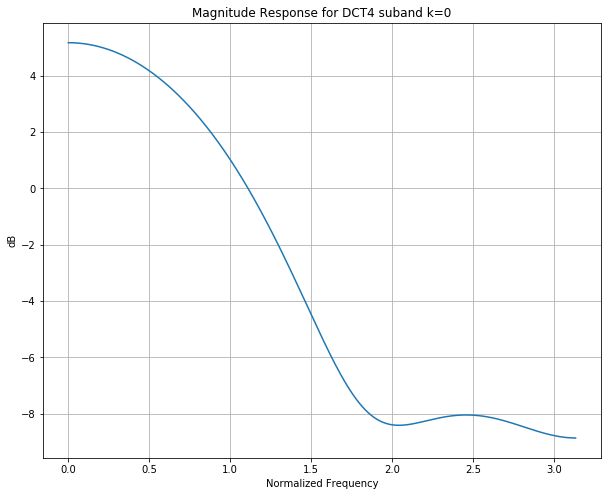

In [20]:
import scipy.signal as sp
import matplotlib.pyplot as plt

W,H=sp.freqz(np.flipud(T[:,0]))

plt.figure(figsize=(10,8))
plt.plot(W,20*np.log10(abs(H)))
plt.xlabel('Normalized Frequency')
plt.ylabel('dB')
plt.title('Magnitude Response for DCT4 suband k=0')
plt.grid()

Observe the low stopband attenuation of less than 20 dB.

A solution is to allow filters with **longer impulse response**, longer than the block size N. This would lead to non-square transform matrices. But non-square matrices are not invertible in general (we can only obtain a pseudo-inverse), hence we would **loose perfect reconstruction**, which is a problem. Alternatively we could have overlapping blocks, which could provide perfect reconstruction, but then we would **lose critical sampling**, again a problem for coding applications.

Our goal is to obtain **longer filters**, have the same block length for **critical sampling**, **and perfect reconstruction**.

This means the transform matrix approach or view comes to its limits. We need new tools. This leads us to the **polyphase** representation, which can be seen as an extension of the transform matrix approach, or as a **mixture** between the **transform view** and the **filter bank view.**

## Polyphase Representation

### Analysis Filter Bank

In [9]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/bL_Xp_ZQ6ss" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

We start with writing our analysis filtering (with FIR filters of length L) and downsampling operation in terms of our block index m and an in block or “phase” index n (with 0≤n≤N−1 ).

The original formulation for our subband signals, for the convolution and downsampling with phase $n_0$ was

$$\large
y^{\downarrow N}_{n_0,k}(m) = \sum_{n=0}^{L-1} x(mN+ n_0 -n) \cdot h_k(n)
$$

In general we assume that the filter length L is an integer multiple of N (we can always zero pad it if necessary). We can now split this sum into a “in block” processing with the **phase index** n that runs from 0 to N−1 , and an “out of block” processing with the **block index** m’ which runs from 0 to the end, by using an index substitution. In this way, the index m’ corresponds to our downsampled index.

To obtain the same ordering for the signal x as we used for our block transform approach (with its index n going up) we substitute $n \rightarrow m' N + N − 1 − n$ and choose the downsampling phase as $n_0=N−1$ to obtain:

$$\large
\begin{equation} \tag{8}
y^{\downarrow N}_{N-1,k} = \sum_{m'=0}^{\frac{L}{N-1}} \sum_{n=0}^{N-1} x(mN-m'N+n) \cdot h_k(mN+N-1-n)
\end{equation}
$$

Observe that this is still our filter bank formulation, but the interesting part here is that the **inner sum** again looks like our **block transform** formulation, with blocks or vectors of size N and an impulse response along the column vector of length N. 

We can reformulate or simplify the inner sum as a vector multiplication when we rewrite the impulse response h(n) as a vector, which contains a sequence of blocks,

$$\large
h_k(m)=[h_k(mN+N-1), h_k(mN+N-2),...,h_k(mN)]
$$

and use the vector of input blocks:

$$\large
x(m)=[x(mN),x(mN+1),...,x(mN+N-1)]
$$

Hence we get:

$$\large
x(m-m') \cdot h_{k}^{T} = \sum_{n=1}^{N-1} x((m-m')\cdot N+n) \cdot h_k(m'N+N-1-n)
$$

Which is now exactly the inner sum of (8). Hence using these 2 vectors we can replace the inner sum by this vector multiplication and rewrite or simplify eq. (8) into:

$$\large
y^{\downarrow N}_{N-1,k} = \sum_{m'=0}^{\frac{L}{N-1}} x(m-m') \cdot h_k(m')
$$

The inner part of this sum is now like our block transform, if we view our impulse response $h_k$ as one (reversed) column of a transform matrix. So again, this is the transform view inside the filter bank view with longer filters, which is why we also have the outer sum, the “out of block” processing, a convolution.

The remaining outer sum now looks like a **convolution** again, but now with a sequence of **blocks instead of samples**, we have a **vector convolution**,

$$\large
y^{\downarrow N}_{N-1,k} = \mathbf{x}(m) * \mathbf{h_k^T}(m)
$$

Observe the our downsampling factor is now “embedded” in our block size.

This has the advantage, that we now can apply the z-transform to this equation to turn the **convolution into a multiplication!**

First we need to z-transform our vectors.

Starting with the signal vector x(m) in the time domain:

$$\large
x(m)=[x(mN),x(mN+1),...,x(mN+N-1)] \\
\large
=  \left[ 
x_0^{\downarrow N}(m),...,x_{N-1}^{\downarrow N}(m)
\right]
$$

we can compute the z-transform of each element of the vector as **polyphase elements**.

$$\large
\begin{equation}
X_n(z) = \sum_{m=0}^\infty n_n^{\downarrow N}(m) \cdot z^{-m}
\end{equation}
$$

The z-transform of our signal vector **x**(m) then becomes the **“polyphase vector”**:

$$\large
\mathbf{X}(z):= [X_0(z), X_1(z),...,X_{N-1}(z)] \\
\large
= \mathbf{X}(z) = \sum_{m=0}^\infty \mathbf{x}(m) \cdot z^{-m}
$$

Since we have N phases, we call this approach **“Polyphase”**.

We use the same method for the vector of **impulse responses**,

$$\large
\mathbf{H}_k(z):= [\mathbf{H}_{N-1,k}(z), \mathbf{H}_{N-2,k}(z),...,\mathbf{H}_{0,k}(z)]
$$

with the polyphase elements: 

$$
\begin{equation}
\large
= \mathbf{H}_{n,k}(z) = \sum_{m=0}^\infty h_k(mN+n) \cdot z^{-m} \\
\large
= \sum_{m=0}^\infty h_{n,k}^{\downarrow N}(m) \cdot z^{-m} 
\end{equation}
$$

The output of our k-th filter is still just a polynomial (not a vector or matrix),

$$\large
\mathbf{Y}_k(z) := \sum_{m=0}^\infty y_{N-1,k}^{\downarrow N}(m) \cdot z^{-m} 
$$

The result of **filtering and downsampling** for the k -th filter in the z-domain is then the following simple **multiplication of vectors**,

$$\large
\mathbf{Y}_k(z) = \mathbf{X}(z) \cdot \mathbf{H_k^T}(z)
$$

**Observe:** Here we rewrote the analysis filtering and subsequent downsampling by this multiplication of vectors in the z-domain!

For an **implementation** we can convert this equation back into the time domain, starting with rewriting the vector multiplication as a sum over the phase index n,

$$\large
\mathbf{Y}_k(z) = \mathbf{X}(z) \cdot \mathbf{H_k^T}(z) \\
\large
= \sum_{n=0}^{N-1} X_n(z) \cdot H_{N-1-n,k}(z)
$$

The multiplications in the z-domain become a sum with simple convolutions in the time domain,

$$\large
\begin{equation}
y_{N-1,k}^{\downarrow N}(m) =\sum_{n=0}^{N-1}  x_n^{\downarrow N}(m) * h_{N-1-n,k}^{\downarrow N}(m)
\end{equation}
$$

This is the **sum over the phases of the convolution of the blocks.**

With this equation we can now implement the polyphase structure in the time domain.

#### Visualization of the polyphase elements and the blocks.

Given a signal x(n) and a downsampling rate of N=2 we get the follwoing blocks and polyphase elements:

<center>
    <img src="./images/msp_11_01_polyphase.jpg" width=500>
</center>

## Python Polyphase Example

Assume a signal x=[5,6,7,8,9,10] and N=3.

Then we get the signal blocks x(m) with m in a range as we need to fit the signal, as x(0)=[5,6,7], x(1)=[8,9,10].

We can use Python Sympy and use **3-dimensional arrays or tensors** to represent the **coefficients** of the different **exponents** of z in the 3rd dimension:

In [10]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/yOEy9l3AYGU" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [1]:
import sympy
import numpy as np
z=sympy.symbols('z')

#The x polyphase matrix is a row vector with 2 blocks:
xp=np.zeros((1,3,2))
xp[0,:,0]=[5,6,7]
xp[0,:,1]=[8,9,10]
Xz=xp[0,:,0] + xp[0,:,1]* z**(-1)
Xz

array([5.0 + 8.0/z, 6.0 + 9.0/z, 7.0 + 10.0/z], dtype=object)

In [2]:
from pprint import *
pprint(Xz)

array([5.0 + 8.0/z, 6.0 + 9.0/z, 7.0 + 10.0/z], dtype=object)


The polyphase elements $X_n(z)$ with phase n=0,... ,N−1 are:

$$
X_0{z}=5+8\cdot z^-1 \\
X_1(z)=6+9\cdot z^-1 \\
X_2(z)=7+10\cdot z^-1 \\
$$

The polyphase vector is:

$$
X(z)=[X_0(z),X_1(z),X_2(z)] \\
=[5+8z^{-1},6+9z^{-1},7+10z^{-1}]
$$

We see that it corresponds to our Python output.

Assume we have the first analysis impulse response of $h_0=[3,4,5,6,7,8]$ for N=3. Then its polyphase vector is in general:

$H_k(z):=[H_{N-1,k}(z),H_{N-2,k}(z),...,H_{0,k}(z)]$

(with our **phases going down**) and for this example, k=0,

$H_0(z)=[5+8z^{-1},4+7z^{-1},3+6z^{-1}]$

In Python this is:

The h polyphase matrix is a **column vector** with 2 blocks:

In [3]:
hp=np.zeros((3,1,2))
hp[:,0,0]=[5,4,3]
hp[:,0,1]=[8,7,6]
Hz=hp[:,0,0] + hp[:,0,1]* z**(-1)
Hz

array([5.0 + 8.0/z, 4.0 + 7.0/z, 3.0 + 6.0/z], dtype=object)

Filtering with downsampling as mult. of the polyphase matrices Xz and Hz:

$$Y_0(z)=X(z)\cdot H_0^T(z)$$

In [4]:
Yz=sympy.expand(np.dot(Xz,Hz))
Yz

70.0 + 230.0/z + 187.0/z**2

## Faster Implementation

In [11]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/LDy5Sf0YlW0" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

We obtain a faster implementation without Sympy if we go back into the time domain, and write our polyphase matrices as **polynomials** with **matrix coefficients**,

$$\large
A(z)=\sum_{n=0}^{N_A-1} A_n \cdot z^{-n} \\
\large
B(z)=\sum_{n=0}^{N_B-1} B_n \cdot z^{-n}
$$

where $A_n$ and $B_n$ contain all the coefficients of $z^{-1}$, and $N_A$ and $N_b$ are the length of the polynomials. Then their product is:

$$\large
A(z)=\sum_{n=0}^{N_A+N_B-2} \sum_{m=0}^{n} A_{n-m} \cdot B_m \cdot z^{-n}
$$

(Remember: ($a_0+a_1\cdot z^{-1})\cdot(b_0+b_1\cdot z^{-1}) = a_0 b_0 + (a_0 b_1 + a_1 b_0)\cdot z^{-1}+a_1 b_1 \cdot z^{-2}$)

Observe: in the z-domain this is a **multiplication of matrix polynomials**, in the time domain this is a **convolution of matrix sequences**.

In **Python** we can program a function polmatmult(A,B),

In [7]:
import numpy as np

def polmatmult( A,B ):
    """polmatmult(A,B)
    multiplies two polynomial matrices (arrays) A and B, where each matrix
    entry is a polynomial.
    Those polynomial entries are in the 3rd dimension
    The third dimension can also be interpreted as containing the (2D)
    coefficient matrices of exponent of z^-1.
    Result is C=A*B;"""
    
    [NAx, NAy, NAz] = np.shape(A);
    [NBx, NBy, NBz] = np.shape(B);
    #Degree +1 of resulting polynomial, with NAz-1 and NBz-1 being the degree of the input polynomials:
    Deg = NAz + NBz -1;
    C = np.zeros((NAx,NBy,Deg));
    #Convolution of matrices:
    for n in range(0,(Deg)):
        for m in range(0,n+1):
            if ((n-m)<NAz and m<NBz):
                C[:,:,n] = C[:,:,n]+ np.dot(A[:,:,(n-m)],B[:,:,m]);
    return C

### Application Example

Take our signal and filter as in our sympy example, but write them as polynomials of vectors; x=[5,6,7,8,9,10] with N=3, and its polyphase representation is $X(z)=[5,6,7]+z^{-1} \cdot [8,9,10].$ Similar for our filter h=[5,4,3,8,7,6] with polyphase representation $H(z)=[5,4,3]+z^{-1} \cdot [8,7,6]$.

These are **polynomials whose coefficients are vectors**. In Python we simply store the sequence of vectors, with the exponent as index in the third (last) dimension:

In [12]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/9InMQH6uACQ" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [8]:
xp=np.zeros((1,3,2))
xp[0,:,0]=[5,6,7]
xp[0,:,1]=[8,9,10]
hp=np.zeros((3,1,2))
hp[:,0,0]=[5,4,3]
hp[:,0,1]=[8,7,6]

yp=polmatmult(xp,hp)
yp

array([[[ 70., 230., 187.]]])

**Observe:** This result in the time domain **corresponds** indeed to the one with Sympy in the **z-domain**!

### Function to turn a signal into a polyphase vector

The following Python function turns a signal (for instance an audio signal) into a polyphase vector that can be used as input for our function polmatmult:

In [13]:
%%html
<center>
<iframe width="560" height="315" src="https://www.youtube.com/embed/E_GeAxCDCcc" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</center>

In [11]:
def x2polyphase(x,N):
    """Converts input signal x (a row vector) into a
    polyphase row vector
    for blocks of length N"""
    #Number of blocks in the signal:
    L = int(np.floor(max(np.shape(x))/N))
    print("L= ", L)
    xp = np.zeros((1,N,L))
    for m in range(0,L):
        xp[0,:,m] = x[m*N+np.arange(N)]
    return xp

### Function to turn a polyphase vector into a sequential signal

In [12]:
def polyphase2x(xp):
    """Converts polyphase input signal xp (a row vector) into a
    contiguos row vector
    For block length N, for 3D polyphase representation
    (exponents of z in the third
    matrix/tensor dimension)"""
    #Number of blocks in the signal
    [r,N,L] = np.shape(xp);
    x = np.zeros((1,N*L));
    for m in range(L):
        x[0,m*N+np.arange(N)]=xp[0,:,m]
    return x